# Import Libraries

In [1]:
# Working with data
import pandas as pd
import numpy as np
import datetime as dt
import re
from collections import Counter

# Saving
import pickle
import joblib

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Modeling
from sklearn.model_selection import \
    train_test_split, GridSearchCV, KFold, cross_val_score

from sklearn.linear_model import\
    LinearRegression, Lasso, Ridge, ElasticNet

from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV

from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.metrics import\
    mean_squared_error, r2_score, mean_absolute_error

from sklearn.pipeline import make_pipeline

import scipy.stats as stats
import scipy.special

import statsmodels.api as sm

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn import feature_selection


In [2]:
import pprint as pp

In [3]:
BNB_RED = '#FF5A5F'
BNB_BLUE = '#00A699'

In [4]:
with open('/Users/luyuankong/Downloads/data/nyc_df.pickle', 'rb') as to_read:
    nyc_df = pickle.load(to_read)

In [ ]:
nyc_df.columns.values

In [ ]:
nyc_df

In [5]:
feature_to_drop = ['id','price','_toilet','host_acceptance_rate']

In [6]:
nyc_df.drop(columns=feature_to_drop,inplace = True)

# data preprocessing

In [ ]:
nyc_df.describe()

In [ ]:
nyc_df.shape

In [ ]:
plt.figure(figsize=(25,25))
sns.heatmap(nyc_df.corr(),
            cmap='twilight',
            annot=False,
            vmin=-1,
            vmax=1,
            square=True);

## Standard Scaling

In [7]:
col_lst = list(nyc_df.columns.values)
num_fea = [
           'latitude','longitude','minimum_nights',
           'number_of_reviews','calculated_host_listings_count',
           'availability_365','host_since_num',
           'bathrooms','bedrooms','guests_included','accommodates','host_response_rate',
           'security_deposit','cleaning_fee','extra_people'
            ]

cat_fea = list(set(col_lst) - set(num_fea))
cat_fea.remove('log_price')

In [8]:
# reorder the columns by numerical and categorical

clean_df = nyc_df[cat_fea + num_fea +['log_price']]

In [9]:
clean_df.shape

(49556, 200)

In [10]:
X = clean_df.iloc[:,:-1]
y = clean_df.iloc[:,-1:]

In [11]:
X['intercept'] = 1

# train test split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [13]:
scaler = StandardScaler()

In [14]:
X_train_cat = X_train.iloc[:,:184]
X_train_num = X_train.iloc[:, 184:]

X_train_num_scaled = scaler.fit_transform(X_train_num)
X_train_scaled = np.column_stack((np.array(X_train_cat), X_train_num_scaled))

X_test_scaled_part = scaler.transform(X_test.iloc[:,184:].values)
X_test_scaled = np.column_stack((X_test.iloc[:, :184].values, X_test_scaled_part))

print(X_train_scaled.shape)
print(X_test_scaled.shape)

(39644, 200)
(9912, 200)


In [15]:
X_train_scaled = pd.DataFrame(X_train_scaled,index = X_train.index, columns= list(X_train.columns))
X_test_scaled = pd.DataFrame(X_test_scaled,index = X_test.index, columns= list(X_test.columns))

In [16]:
X_train_scaled.head()

,Babysitter_recommendations,Hot_water,Chelsea,Building_staff,Bath_towel,Air_conditioning,Heating,Wide_hallways,Laptop_friendly_workspace,Pack_’n_Play/travel_crib,...,host_since_num,bathrooms,bedrooms,guests_included,accommodates,host_response_rate,security_deposit,cleaning_fee,extra_people,intercept
113,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,2.094417,-0.342631,2.577270,0.437555,-0.458751,0.869786,-0.146854,-0.575866,0.453535,0.0
47677,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,-1.763198,-0.342631,2.577270,-0.455486,0.660432,0.869786,-0.412322,-0.924458,-0.594255,0.0
47079,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,-1.750973,-0.342631,-0.230576,-0.455486,-1.018342,0.869786,-0.412322,-0.401569,0.243977,0.0
45614,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,-1.295306,2.245394,1.173347,2.223636,1.779614,0.827471,0.544319,1.602840,-0.384697,0.0
50771,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-1.457568,-0.342631,-0.230576,-0.455486,0.660432,0.869786,0.305159,0.818506,-0.594255,0.0


In [17]:
X_test_scaled.head()

,Babysitter_recommendations,Hot_water,Chelsea,Building_staff,Bath_towel,Air_conditioning,Heating,Wide_hallways,Laptop_friendly_workspace,Pack_’n_Play/travel_crib,...,host_since_num,bathrooms,bedrooms,guests_included,accommodates,host_response_rate,security_deposit,cleaning_fee,extra_people,intercept
23429,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.349543,2.245394,1.173347,-0.455486,1.220023,-1.245980,-0.412322,-0.924458,-0.594255,0.0
15367,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.348406,-0.342631,-0.230576,-0.455486,-0.458751,-1.245980,-0.412322,-0.924458,-0.594255,0.0
38752,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,1.667645,-0.342631,-0.230576,-0.455486,-0.458751,0.869786,0.305159,-0.401569,-0.594255,0.0
7428,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.158385,3.539406,-0.230576,-0.455486,-1.018342,-1.245980,-0.412322,-0.575866,1.501325,0.0
45358,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,-1.536476,-0.342631,-0.230576,2.223636,2.898796,0.869786,-0.412322,0.121320,0.034419,0.0


In [18]:
X_train_scaled['intercept'] = 1
X_test_scaled['intercept'] = 1

In [ ]:
# with open('Downloads/data/X_train_scaled.pickle', 'wb') as to_write:
#     pickle.dump(X_train_scaled, to_write)
    
# with open('Downloads/data/X_test_scaled.pickle', 'wb') as to_write:
#     pickle.dump(X_test_scaled, to_write)

# OLS statsmodel

In [19]:
# our vanilla ols with scaled data

model = sm.OLS(y_train, X_train_scaled)

fit = model.fit()

y_pred = fit.predict(X_test_scaled)

fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     427.2
Date:                Wed, 25 Mar 2020   Prob (F-statistic):               0.00
Time:                        14:06:58   Log-Likelihood:                -16769.
No. Observations:               39644   AIC:                         3.392e+04
Df Residuals:                   39454   BIC:                         3.555e+04
Df Model:                         189                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Babysitter_recommendations         0.0094      0.017      0.559      0.576      -0.023       0.042
Hot_water                         -0.0029      0.005     -0.523      0.601      -0.014       0.008
Chelsea                            0.2685      0.014     19.643      0.000       0.242       0.295
Building_staff                    -0.0095      0.069     -0.138      0.890      -0.145       0.126
Bath_towel                         0.0439      0.020      2.168      0.030       0.004       0.084
Air_conditioning                   0.0592      0.006     10.443      0.000       0.048       0.070
Heating                           -0.0103      0.008     -1.211      0.226      -0.027       0.006
Wide_hallways                      0.0074      0.033      0.223      0.824      -0.058       0.073
Laptop_friendly_workspace         -0.0204      0.004     -4.566      0.000      -0.029      -0.012
Pack_’n_Play/travel_crib           0.0452      0.013      3.568      0.000       0.020       0.070
Crib                               0.0128      0.016      0.775      0.438      -0.019       0.045
Townhouse                         -0.1191      0.020     -5.847      0.000      -0.159      -0.079
Pull-out Sofa                     -0.0311      0.058     -0.538      0.590      -0.144       0.082
High_chair                        -0.0182      0.016     -1.133      0.257      -0.050       0.013
Iron                              -0.0059      0.005     -1.195      0.232      -0.016       0.004
Shower_gel                        -0.0039      0.012     -0.318      0.750      -0.028       0.020
Bushwick                          -0.1011      0.009    -10.654      0.000      -0.120      -0.083
Entire home/apt                    0.3103      0.028     10.972      0.000       0.255       0.366
Mini_bar                          -0.0316      0.055     -0.572      0.567      -0.140       0.077
Beach_essentials                  -0.0223      0.026     -0.866      0.386      -0.073       0.028
TV                                 0.0632      0.005     13.797      0.000       0.054       0.072
Dishes_and_silverware             -0.0078      0.008     -1.003      0.316      -0.023       0.007
host_has_profile_pic              -0.0041      0.036     -0.114      0.909      -0.075       0.067
Baby_monitor                       0.0026      0.040      0.066      0.948      -0.075       0.080
Family/kid_friendly                0.0100      0.005      1.977      0.048    8.76e-05       0.020
Bathtub_with_bath_chair            0.0029      0.242      0.012      0.991      -0.472       0.478
Firm_mattress                     -0.0470      0.064     -0.734      0.463      -0.172       0.078
Mini_fridge                        0.0755      0.065      1.160      0.246      -0.052       0.203
Indoor_firepla

In [20]:
# 1st round of dropping cols with high p values

for col in ['Accessible-height_toilet','Single_level_home','Smoke_detector',
           'Bathrobes','Room-darkening_shades','Washer','Well-lit_path_to_entrance',
           'Flat_path_to_guest_entrance','Dog(s)','Table_corner_guards','Other_pet(s)',
            'Lockbox','Disabled_parking_spot','Buzzer/wireless_intercom','Bathtub_with_bath_chair',
            'Building_staff','Babysitter_recommendations','Children’s_dinnerware',
            'Wide_clearance_to_shower','Paid_parking_on_premises','host_has_profile_pic',
            'Extra_space_around_bed','Lake_access','Game_console','Baby_monitor',
            'Luggage_dropoff_allowed','Mobile_hoist','Hot_water','First_aid_kit',
            'Shower_gel','Step-free_shower','Accessible-height_bed','Fire_extinguisher',
            'Wide_hallways','Wide_entrance_for_guests','Safety_card','Garden_or_backyard',
            'Serviced apartment','No_stairs_or_steps_to_enter','Outlet_covers',
            'Wide_doorway_to_guest_bathroom','Fixed_grab_bars_for_shower','Electric_profiling_bed',
           'Barbecue_utensils','Mini_bar','Smoking_allowed','High_chair','Hot_water_kettle','Pets_live_on_this_property',
           'Dishes_and_silverware','Ethernet_connection','Free_parking_on_premises','Bluetooth_speaker',
           'Bread_maker','Essentials','Host_greets_you']:
    del X_train_scaled[col]
    del X_test_scaled[col]

In [21]:
model1 = sm.OLS(y_train, X_train_scaled)

fit = model1.fit()

y_pred = fit.predict(X_test_scaled)

print('R^2 Score out sample: ', round(r2_score(y_test, y_pred), 3))

fit.summary()


R^2 Score out sample:  0.67


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.671
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     593.3
Date:                Wed, 25 Mar 2020   Prob (F-statistic):               0.00
Time:                        14:07:06   Log-Likelihood:                -16797.
No. Observations:               39644   AIC:                         3.387e+04
Df Residuals:                   39507   BIC:                         3.504e+04
Df Model:                         136                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Chelsea                            0.2672      0.014     19.580      0.000       0.240       0.294
Bath_towel                         0.0358      0.019      1.848      0.065      -0.002       0.074
Air_conditioning                   0.0595      0.006     10.513      0.000       0.048       0.071
Heating                           -0.0102      0.008     -1.203      0.229      -0.027       0.006
Laptop_friendly_workspace         -0.0203      0.004     -4.574      0.000      -0.029      -0.012
Pack_’n_Play/travel_crib           0.0432      0.012      3.519      0.000       0.019       0.067
Crib                               0.0024      0.016      0.152      0.879      -0.028       0.033
Townhouse                         -0.1130      0.017     -6.491      0.000      -0.147      -0.079
Pull-out Sofa                     -0.0291      0.058     -0.505      0.614      -0.142       0.084
Iron                              -0.0054      0.005     -1.097      0.272      -0.015       0.004
Bushwick                          -0.1004      0.009    -10.613      0.000      -0.119      -0.082
Entire home/apt                    0.2979      0.028     10.786      0.000       0.244       0.352
Beach_essentials                  -0.0205      0.025     -0.806      0.420      -0.070       0.029
TV                                 0.0634      0.005     13.870      0.000       0.054       0.072
Family/kid_friendly                0.0102      0.005      2.020      0.043       0.000       0.020
Firm_mattress                     -0.0436      0.064     -0.683      0.495      -0.169       0.081
Mini_fridge                        0.1282      0.141      0.910      0.363      -0.148       0.404
Indoor_fireplace                   0.1022      0.010     10.176      0.000       0.082       0.122
Bedroom_comforts                   0.0358      0.019      1.848      0.065      -0.002       0.074
Internet                          -0.0094      0.005     -1.707      0.088      -0.020       0.001
Murray Hill                        0.2514      0.019     13.060      0.000       0.214       0.289
Long_term_stays_allowed           -0.0264      0.006     -4.657      0.000      -0.038      -0.015
Carbon_monoxide_detector           0.0167      0.004      3.729      0.000       0.008       0.025
Oven                               0.0365      0.009      3.958      0.000       0.018       0.055
Changing_table                    -0.0304      0.031     -0.966      0.334      -0.092       0.031
Boutique hotel                     0.3059      0.027     11.200      0.000       0.252       0.359
Pool                               0.0359      0.016      2.212      0.027       0.004       0.068
Bedford-Stuyvesant                -0.0786      0.008     -9.975      0.000      -0.094      -0.063
Futon         

## Multicollinearity

run VIF to check multicollinearity

In [22]:
vif = pd.DataFrame()
vif["VIF Factor"] = [
    variance_inflation_factor(X_train_scaled.values, i)
    for i in range(X_train_scaled.shape[1])
]
vif["features"] = X_train_scaled.columns

/Users/luyuankong/anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [ ]:
print(vif, file=open("vif.txt", "a"))
vif.sort_values(by='VIF Factor',ascending=False)[0:30]

In [23]:
# 2nd round of dropping cols with high vif

for col in ['Bath_towel','Bathroom_essentials','Slippers',
           'Safe','Mini_fridge','Body_soap',
           'Bottled_water','Toilet_paper','Private room','Bedroom_comforts',
            'Apartment','Wide_entryway','Wide_entrance','Bed_linens','Stove']:
    del X_train_scaled[col]
    del X_test_scaled[col]

In [24]:
model2 = sm.OLS(y_train, X_train_scaled)

fit = model2.fit()

y_pred = fit.predict(X_test_scaled)

print('R^2 Score out sample: ', round(r2_score(y_test, y_pred), 3))

fit.summary()


R^2 Score out sample:  0.667


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     624.8
Date:                Wed, 25 Mar 2020   Prob (F-statistic):               0.00
Time:                        14:08:09   Log-Likelihood:                -16917.
No. Observations:               39644   AIC:                         3.409e+04
Df Residuals:                   39515   BIC:                         3.520e+04
Df Model:                         128                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Chelsea                            0.2701      0.014     19.753      0.000       0.243       0.297
Air_conditioning                   0.0600      0.006     10.583      0.000       0.049       0.071
Heating                           -0.0104      0.008     -1.230      0.219      -0.027       0.006
Laptop_friendly_workspace         -0.0179      0.004     -4.020      0.000      -0.027      -0.009
Pack_’n_Play/travel_crib           0.0480      0.012      3.901      0.000       0.024       0.072
Crib                               0.0188      0.016      1.206      0.228      -0.012       0.049
Townhouse                          0.0114      0.011      1.036      0.300      -0.010       0.033
Pull-out Sofa                     -0.0339      0.058     -0.585      0.558      -0.147       0.080
Iron                              -0.0047      0.005     -0.956      0.339      -0.014       0.005
Bushwick                          -0.1031      0.009    -10.869      0.000      -0.122      -0.084
Entire home/apt                    0.4608      0.005     85.037      0.000       0.450       0.471
Beach_essentials                  -0.0203      0.026     -0.793      0.428      -0.070       0.030
TV                                 0.0651      0.005     14.224      0.000       0.056       0.074
Family/kid_friendly                0.0104      0.005      2.066      0.039       0.001       0.020
Firm_mattress                     -0.0455      0.064     -0.711      0.477      -0.171       0.080
Indoor_fireplace                   0.1024      0.010     10.177      0.000       0.083       0.122
Internet                          -0.0077      0.005     -1.399      0.162      -0.018       0.003
Murray Hill                        0.2615      0.019     13.565      0.000       0.224       0.299
Long_term_stays_allowed           -0.0307      0.006     -5.399      0.000      -0.042      -0.020
Carbon_monoxide_detector           0.0161      0.004      3.594      0.000       0.007       0.025
Oven                               0.0134      0.008      1.676      0.094      -0.002       0.029
Changing_table                    -0.0378      0.032     -1.200      0.230      -0.100       0.024
Boutique hotel                     0.4633      0.025     18.651      0.000       0.415       0.512
Pool                               0.0401      0.016      2.461      0.014       0.008       0.072
Bedford-Stuyvesant                -0.0800      0.008    -10.118      0.000      -0.095      -0.064
Futon                             -0.0879      0.057     -1.532      0.125      -0.200       0.025
BBQ_grill                         -0.0169      0.011     -1.509      0.131      -0.039       0.005
Baking_sheet                      -0.0225      0.019     -1.215      0.225      -0.059       0.014
Waterfront    

# OLS Skitlearn

In [ ]:
lm = LinearRegression()

lm.fit(X_train_scaled, y_train)

kf = KFold(n_splits=10, shuffle=True, random_state=42) # define splits for cross validation

r2_lm = np.mean(
    cross_val_score(lm, X_train_scaled, y_train, cv=kf, scoring='r2'))


In [ ]:
print('OLS model R^2 in sample', round(r2_lm,2))

In [ ]:
y_pred_lm = lm.predict(X_test_scaled)

In [ ]:
print('OLS model R^2 out sample', round(lm.score(X_test_scaled, y_test),2))

In [ ]:
# Plot actual vs predicted
plt.figure(figsize=(10, 8))
plt.plot([3, 7], [3, 7], '--', c=BNB_RED)
plt.scatter(y_pred_lm, y_test, color='skyblue', alpha=0.3)
sns.despine()
plt.xlabel('Predicted Prices log($)', size=16)
plt.ylabel('Actual Prices log($)', size=16)
plt.title('Actual vs Predicted Prices (OLS)', size=18)

In [ ]:
resid_lm = y_test - y_pred_lm  # Calculate residuals

In [ ]:
# Plot distribution of residuals
plt.figure(figsize=(8, 5))
sns.distplot(resid_lm,color='skyblue')
plt.xlabel('Target Residuals', size=14)
sns.despine()
plt.title('Distribution of Residuals', size=16)

In [ ]:
# Plot residuals vs predicted target values
plt.figure(figsize=(8, 5))
plt.scatter(y_pred_lm, resid_lm, alpha=0.5, color='skyblue')
plt.xlabel('Predicted Prices log($)', size=14)
sns.despine()
plt.ylabel('Price Residuals log($)', size=14)
plt.plot([2, 8], [0, 0], '--', color='red')
plt.title('Residuals vs Predicted Prices (OLS)', size=14)

# Regularization

## LASSO

In the LASSO, We penalize the sum of the absolute values of the coefficients.

Notice how LASSO sets many variables to 0 (with a high enough alpha parameter). This is its feature selection 

property. Least Absolute Shrinkage and Selection Operator -- the shrinkage part means making the coefficients smaller

by penalizing their size in the cost function, and the selection part is zeroing out coefficients. 

In [ ]:
alphavec = 10**np.linspace(-2,2,200)

kf = KFold(n_splits=5, shuffle=True, random_state = 42)

lasso_model = LassoCV(alphas = alphavec, cv=kf)

lasso_model.fit(X_train_scaled, y_train)

print(' LASSO Best alpha: ' , lasso_model.alpha_)

#Make predictions on the test set using the new model
y_pred = lasso_model.predict(X_test_scaled)

print('LASSO R^2 Score in sample: ', round(r2_score(y_test, y_pred), 2))

print('LASSO Mean Ablsolute Error: ', round(mean_absolute_error(y_test, y_pred),2))


In [ ]:
pp.pprint(list(zip(X_train_scaled.columns, lasso_model.coef_)))

## Ridge

in Ridge Regression we penalize the sum of the squares of the coefficients. Ridge smoothed out all of the 

coefficients, bringing them closer to 0 but not discarding any of them. Also, it gave roughly equal weight to the 

highly collinear features.

In [ ]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

kf = KFold(n_splits=5, shuffle=True, random_state = 42)

ridge_model = RidgeCV(alphas = alphavec, cv=kf)

ridge_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = ridge_model.predict(X_test_scaled)

print('Ridge best alpha: ', ridge_model.alpha_)

print('Ridge R^2 Score out sample: ', round(r2_score(y_test, y_pred), 2))

print('Ridge Mean Ablsolute Error: ', round(mean_absolute_error(y_test, y_pred), 2))


## ElasticNet

The elastic net is a regularized regression method where the penalty function is a linear combination of the lasso ($L_{1}$) and ridge ($L_{2}$) penalties

The elastic net penalty function can be written as

penalty = alpha * l1_ratio * ||w||_1 + 0.5 * alpha * (1 - l1_ratio) * ||w||^2

alpha is the overall regularization parameter

l1_ratio controls the relative weight of the lasso ($L_{1}$) and ridge ($L_{2}$) penalties:

l1_ratio = 1 is lasso; l1_ratio = 0 is ridge.

In [ ]:
l1_ratio_lst = [.1, 0.2, 0.3, 0.4, .5, .7, .9, .95, .99, 1] 
alphavec = 10**np.linspace(-2,2,200)

kf = KFold(n_splits=5, shuffle=True, random_state = 42)

elas_model = ElasticNetCV(alphas = alphavec, l1_ratio = l1_ratio_lst, cv=kf)

elas_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = elas_model.predict(X_test_scaled)

print('Elas best alpha: ', elas_model.alpha_)
print('Elas best l1_ration: ', elas_model.l1_ratio_)

print('Elas R^2 Score out sample: ', round(r2_score(y_test, y_pred), 2))

print('Elas Mean Ablsolute Error: ', round(mean_absolute_error(y_test, y_pred), 2))


In [ ]:
pp.pprint(list(zip(X_train_scaled.columns, elas_model.coef_)))

In [ ]:
elas_coef_lst = list(zip(X_train_scaled.columns, elas_model.coef_))

In [ ]:
# with open('Downloads/data/X_train_scaled_1.pickle', 'wb') as to_write:
#     pickle.dump(X_train_scaled, to_write)
    
# with open('Downloads/data/X_test_scaled_1.pickle', 'wb') as to_write:
#     pickle.dump(X_test_scaled, to_write)

In [ ]:
with open('Downloads/data/X_train_scaled_1.pickle', 'rb') as to_read:
    X_train_scaled = pickle.load(to_read)
with open('Downloads/data/X_test_scaled_1.pickle', 'rb') as to_read:
    X_test_scaled = pickle.load(to_read)

In [ ]:
print('Number of Features on train set', X_train_scaled.shape[1])

In [ ]:
print('Number of Features on test set', X_train_scaled.shape[1])

# Feature Selection

still have too many features, let's remove some features one last round based on the regularization results

In [ ]:
# take a look the features which coeffcients' value
for name, coeff in elas_coef_lst:
    if abs(coeff) < 0.02:
        print(name, round(coeff,2))

In [25]:
to_drop_lst = ['host_identity_verified','Long Island City','Stair_gates','Financial District',
               'Park Slope','Beachfront','Suitable_for_events','Oven','Cooking_basics',
               'Guest suite','Pocket_wifi','Carbon_monoxide_detector','Clinton Hill',
               'Pull-out Sofa','Pool','Smart_lock',
               'Free_street_parking','latitude','longitude',
               'Boutique hotel','Handheld_shower_head','Fireplace_guards',
              'Waterfront','Lock_on_bedroom_door','Pack_’n_Play/travel_crib',
               'Shower_chair','24-hour_check-in','Paid_parking_off_premises',
              'Dryer','House','Cleaning_before_checkout','Kitchenette','Internet',
              'Ski-in/Ski-out','Extra_pillows_and_blankets','EV_charger',
              'Fixed_grab_bars_for_toilet','Baby_bath','Full_kitchen','Iron', 'BBQ_grill',
              'Air_purifier', 'Keypad','Wheelchair_accessible', 'Long_term_stays_allowed',
              'Window_guards', 'Baking_sheet','Children’s_books_and_toys','Cat(s)', 'Crib',
              'Beach_essentials', 'Condominium', 'Trash_can','Pets_allowed','Ground_floor_access',
              'Private_bathroom','Prospect-Lefferts Gardens','Private_living_room','Changing_table',
              'Cable_TV','Heating','Family/kid_friendly','Townhouse','Hangers','Hot_tub',
               'calculated_host_listings_count']

In [26]:
# 3rd round of feature selection by dropping the features

for col in to_drop_lst:
    del X_train_scaled[col]
    del X_test_scaled[col]

In [ ]:
print('Number of Features on train set', X_train_scaled.shape[1])

# Refit selected features into model

## ols statsmodel

In [39]:
model3 = sm.OLS(y_train, X_train_scaled)

fit = model3.fit()

y_pred = fit.predict(X_test_scaled)

fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                     1141.
Date:                Wed, 25 Mar 2020   Prob (F-statistic):               0.00
Time:                        14:13:53   Log-Likelihood:                -18533.
No. Observations:               39644   AIC:                         3.719e+04
Df Residuals:                   39581   BIC:                         3.773e+04
Df Model:                          62                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Chelsea                       0.3949      0.014     29.088      0.000       0.368       0.422
Air_conditioning              0.0702      0.006     12.064      0.000       0.059       0.082
Laptop_friendly_workspace    -0.0263      0.004     -5.989      0.000      -0.035      -0.018
Bushwick                     -0.1526      0.009    -16.082      0.000      -0.171      -0.134
Entire home/apt               0.4830      0.005     91.272      0.000       0.473       0.493
TV                            0.0739      0.005     16.287      0.000       0.065       0.083
Firm_mattress                -0.0507      0.066     -0.763      0.446      -0.181       0.080
Indoor_fireplace              0.1064      0.010     10.316      0.000       0.086       0.127
Murray Hill                   0.3214      0.020     16.438      0.000       0.283       0.360
Bedford-Stuyvesant           -0.0976      0.008    -12.468      0.000      -0.113      -0.082
Futon                        -0.0857      0.037     -2.348      0.019      -0.157      -0.014
Hair_dryer                    0.0407      0.005      8.408      0.000       0.031       0.050
Private_entrance              0.0006      0.005      0.106      0.915      -0.010       0.011
Williamsburg                  0.1435      0.008     17.988      0.000       0.128       0.159
Greenpoint                    0.1244      0.014      9.018      0.000       0.097       0.151
Dishwasher                    0.1255      0.007     19.218      0.000       0.113       0.138
Patio_or_balcony              0.0353      0.008      4.581      0.000       0.020       0.050
East Flatbush                -0.1551      0.019     -7.988      0.000      -0.193      -0.117
East Village                  0.3601      0.011     33.417      0.000       0.339       0.381
Loft                          0.1465      0.012     11.852      0.000       0.122       0.171
Midtown                       0.4779      0.012     39.990      0.000       0.454       0.501
Real Bed                     -0.0224      0.025     -0.893      0.372      -0.072       0.027
Breakfast                     0.0429      0.007      5.743      0.000       0.028       0.058
Elevator                      0.0960      0.005     18.213      0.000       0.086       0.106
Flatbush                     -0.1893      0.018    -10.758      0.000      -0.224      -0.155
host_is_superhost             0.0345      0.006      6.221      0.000       0.024       0.045
Self_check-in                -0.0150      0.005     -2.913      0.004      -0.025      -0.005
Lower East Side               0.3431      0.015     23.395      0.000       0.314       0.372
Crown Heights                -0.1127      0.011    -10.110      0.000      -0.135      -0.091
Upper West Side               0.2610      0.011     24.625      0.000      

In [40]:
print('Parameters:\n', fit.params)

Parameters:
 Chelsea                      0.394914
Air_conditioning             0.070201
Laptop_friendly_workspace   -0.026318
Bushwick                    -0.152611
Entire home/apt              0.482957
TV                           0.073851
Firm_mattress               -0.050664
Indoor_fireplace             0.106440
Murray Hill                  0.321387
Bedford-Stuyvesant          -0.097580
Futon                       -0.085745
Hair_dryer                   0.040726
Private_entrance             0.000558
Williamsburg                 0.143545
Greenpoint                   0.124377
Dishwasher                   0.125467
Patio_or_balcony             0.035319
East Flatbush               -0.155078
East Village                 0.360115
Loft                         0.146511
Midtown                      0.477912
Real Bed                    -0.022447
Breakfast                    0.042884
Elevator                     0.096040
Flatbush                    -0.189313
host_is_superhost            0.034503

In [41]:
key = list(fit.params.index)

In [42]:
values = list(fit.params.values)

In [43]:
dic = dict(zip(key,values))

In [44]:
final_df = pd.DataFrame({'Feature':fit.params.index, 'Coefficient':fit.params.values})

In [45]:
top_features = (list(final_df[:-1][abs(final_df['Coefficient']) > 0.08]
                  ['Feature']) )

/Users/luyuankong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [46]:
coeff_lst = [dic[i] for i in top_features]

In [47]:
ols_coeff = list(zip(top_features, coeff_lst))

In [48]:
ols_coeff = sorted(ols_coeff, key=(lambda x: x[1]), reverse=True)

In [49]:
ols_top_coefs_df = pd.DataFrame(ols_coeff)

In [50]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10
plt.rc('font', size=20) 

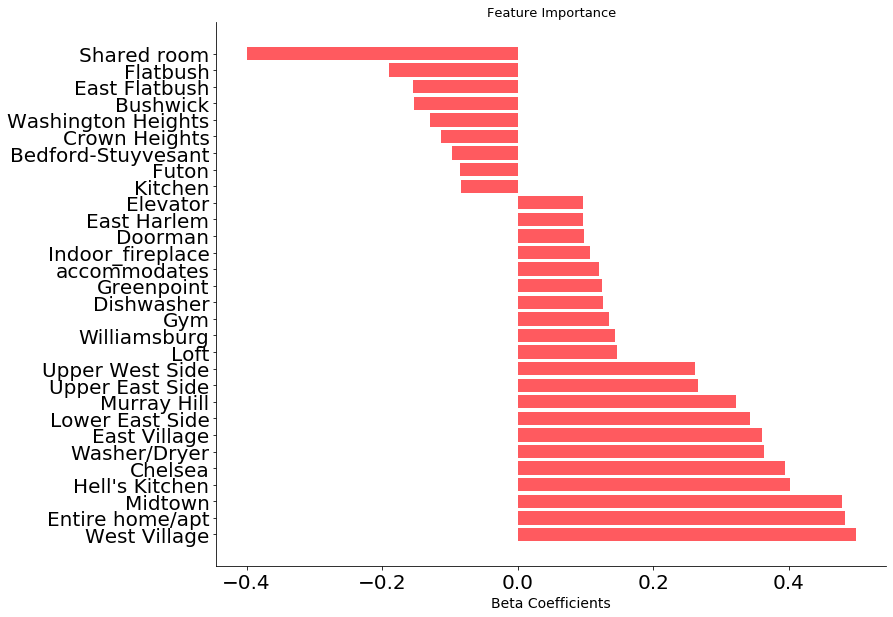

In [51]:
plt.barh([x[0] for x in ols_coeff], width=[x[1] for x in ols_coeff],color = BNB_RED )
plt.title('Feature Importance', fontdict = {'fontsize' : 13})
plt.grid(b=False)
plt.xlabel('Beta Coefficients', size=14)
sns.despine()

In [52]:
log_wd_std = np.std(X_train_scaled['Washer/Dryer'])

In [54]:
log_wd_std

0.01506548850827082

In [55]:
0.3629 / log_wd_std

24.08816679265137

In [ ]:
print('Predicted values: ', fit.predict())

## lm sklearn

In [28]:
lm = LinearRegression()

lm.fit(X_train_scaled, y_train)

kf = KFold(n_splits=10, shuffle=True, random_state=42) # define splits for cross validation

r2_lm = np.mean(
    cross_val_score(lm, X_train_scaled, y_train, cv=kf, scoring='r2'))


In [29]:
print('OLS model R^2 in sample', round(r2_lm,2))

OLS model R^2 in sample 0.64


In [30]:
y_pred_lm = lm.predict(X_test_scaled)

In [38]:
log_wd_std

0.01506548850827082

In [31]:
adj_r2(y_test,y_pred_lm)

NameError: name 'adj_r2' is not defined

In [ ]:
mean_absolute_error(y_test,y_pred)

## Ridge

In [ ]:
def adj_r2(y_test,y_pred):
    """
    calculate adjusted r squared score
    """
    p = X_train_scaled.shape[1] # number of features
    n = X_train_scaled.shape[0] # number of observations
    r2 = r2_score(y_test, y_pred)
    return 1 - (1 - r2)*((n-1)/(n-p-1))

In [ ]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

kf = KFold(n_splits=5, shuffle=True, random_state = 42)

ridge_model = RidgeCV(alphas = alphavec, cv=kf)

ridge_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = ridge_model.predict(X_test_scaled)

print('Ridge best alpha: ', ridge_model.alpha_)

print('Ridge R^2 Score out sample: ', round(r2_score(y_test, y_pred), 2))

print('Ridge Adjusted R^2 Score out sample: ', round(adj_r2(y_test,y_pred),2))


In [ ]:
ridge_model.coef_

## elastic net regression

In [ ]:
l1_ratio_lst = [.1, 0.2, 0.3, 0.4, .5, .7, .9, .95, .99, 1] 
alphavec = 10**np.linspace(-2,2,200)

kf = KFold(n_splits=5, shuffle=True, random_state = 42)

elas_model1 = ElasticNetCV(alphas = alphavec, l1_ratio = l1_ratio_lst, cv=kf)

elas_model1.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = elas_model1.predict(X_test_scaled)

print('Elas best alpha: ', elas_model1.alpha_)
print('Elas best l1_ration: ', elas_model1.l1_ratio_)

print('Elas R^2 Score out sample: ', round(r2_score(y_test, y_pred), 2))


In [ ]:
sorted((list(zip(X_train_scaled.columns, elas_model1.coef_))),key=lambda x: x[1])